# Plug-and-play ADMM
https://arxiv.org/abs/1605.01710

https://www.mathworks.com/matlabcentral/fileexchange/60641-plug-and-play-admm-for-image-restoration

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd drive/MyDrive/ECE500/project/data
%ls

%pip install bm3d

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ECE500/project/data
pepper.bmp  test.png


## ADMM

Imports and utils

In [2]:
import numpy as np
from scipy.signal import convolve2d


def imfilter(x, h):
  return convolve2d(x, h, mode='same', boundary='wrap')


def imresize(x, K):
  return np.repeat(np.repeat(x, K, axis=0), K, axis=1)


def upsample2(x, K):
  m, n = x.shape
  y = np.zeros((m * K, n * K), dtype=x.dtype)
  y[::K, ::K] = x
  return y


def downsample2(x, K):
  return x[::K, ::K]


def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

### Super-resolution

In [3]:
from numpy.fft import fft2, ifft2


def plug_and_play_admm_super(y, h, K, lmbda, denoiser,
                              rho=1.0, tol=1e-3, gamma=1.0, max_iteration=100):
  def G(x):
    return downsample2(imfilter(x, h), K)


  def Gt(x):
    return imfilter(upsample2(x, K), h)


  # GGt
  hth = convolve2d(h, np.rot90(h, 2), mode='full')
  yc = hth.shape[0] // 2
  xc = hth.shape[1] // 2
  L = hth.shape[0] // K
  i_range = np.arange(-L // 2, L // 2)
  j_range = np.arange(-L // 2, L // 2)
  g = hth[yc + K * i_range - 1][:, xc + K * j_range - 1]
  GGt = np.abs(fft2(g, s=y.shape))

  # Gty
  Gty = Gt(y)

  # Initialize
  v = imresize(y, K)
  x = v.copy()
  u = np.zeros(v.shape)

  delta = np.inf

  N = v.shape[0] * v.shape[1]

  # Algorithm 1
  iteration = 1
  while delta > tol and iteration <= max_iteration: # (18)
    x_old = x
    v_old = v
    u_old = u

    # Update x
    # (23)
    xtilde = v - u
    rhs = Gty + rho * xtilde
    x = np.real((rhs - Gt(ifft2(fft2(G(rhs))/(GGt + rho))))/rho)

    # Denoising
    sigma = np.sqrt(lmbda/rho)
    v = denoiser(np.clip(x + u, 0, 1), sigma)

    # Update u
    u = u + (x - v)

    # (15)
    delta = (1/np.sqrt(N)) * (np.linalg.norm(x - x_old) \
                            + np.linalg.norm(v - v_old) \
                            + np.linalg.norm(u - u_old))
    rho = rho*gamma

    print(f"iteration: {iteration}, delta: {delta}")
    iteration += 1

  return x

### Deblur

In [4]:
from numpy.fft import fftn, ifftn


def plug_and_play_admm_deblur(y, h, lmbda, denoiser,
                              rho=1.0, tol=1e-3, gamma=1.0, max_iteration=100):
  dim = y.shape
  N = dim[0]*dim[1]

  Hty = imfilter(y, h)
  eigHtH = np.abs(fftn(h, dim))**2

  x = 0.5 * np.ones(dim)
  u = 0.5 * np.ones(dim)
  v = np.zeros(dim)

  delta = np.inf

  # Algorithm 1
  iteration = 1
  while delta > tol and iteration <= max_iteration: # (18)
    x_old = x
    v_old = v
    u_old = u

    # Update x
    rhs = fftn(Hty + rho * (v - u), dim)
    x = np.real(ifftn(rhs / (eigHtH + rho), dim))

    # Denoising
    sigma = np.sqrt(lmbda/rho)
    v = denoiser(np.clip(x+u, 0, 1), sigma)

    # Update u
    u = u + (x-v)

    # (15)
    delta = (1/np.sqrt(N)) * (np.linalg.norm(x-x_old) \
                            + np.linalg.norm(v-v_old) \
                            + np.linalg.norm(u-u_old))

    rho = rho*gamma

    print(f"iteration: {iteration}, delta: {delta}")
    iteration += 1

  return v

## Denoisers

In [5]:
import scipy.ndimage as ndimage
import skimage
import bm3d


def denoise_bm3d(v, sigma):
  return bm3d.bm3d(v, sigma)


def denoise_nl_means(v, sigma):
  return skimage.restoration.denoise_nl_means(v, h=sigma)


def denoise_tv_chambolle(v, sigma):
  return skimage.restoration.denoise_tv_chambolle(v, weight=1/sigma**2)


def denoise_median(v, sigma):
  return ndimage.median_filter(v, size=3)

## Image Reconstruction

### Super-resolution

iteration: 1, delta: 0.03576354358665013
iteration: 2, delta: 0.04988162525819005
iteration: 3, delta: 0.01917259089810859
iteration: 4, delta: 0.007821273837566058
iteration: 5, delta: 0.005444319064724839
iteration: 6, delta: 0.0045022450219584864
iteration: 7, delta: 0.003769263530873295
iteration: 8, delta: 0.003064757948481539
iteration: 9, delta: 0.0026316757540244206
iteration: 10, delta: 0.0024239395995893265
iteration: 11, delta: 0.002210125137102204
iteration: 12, delta: 0.002025784621575812
iteration: 13, delta: 0.0017901627991387431
iteration: 14, delta: 0.0016728838288726751
iteration: 15, delta: 0.0014734879645836776
iteration: 16, delta: 0.001328394381536528
iteration: 17, delta: 0.0011916177475259247
iteration: 18, delta: 0.0011495789074339104
iteration: 19, delta: 0.0011503772661672887
iteration: 20, delta: 0.0011089509900423877
iteration: 21, delta: 0.0011098985678913273
iteration: 22, delta: 0.0011263716129696314
iteration: 23, delta: 0.0009729949697474422


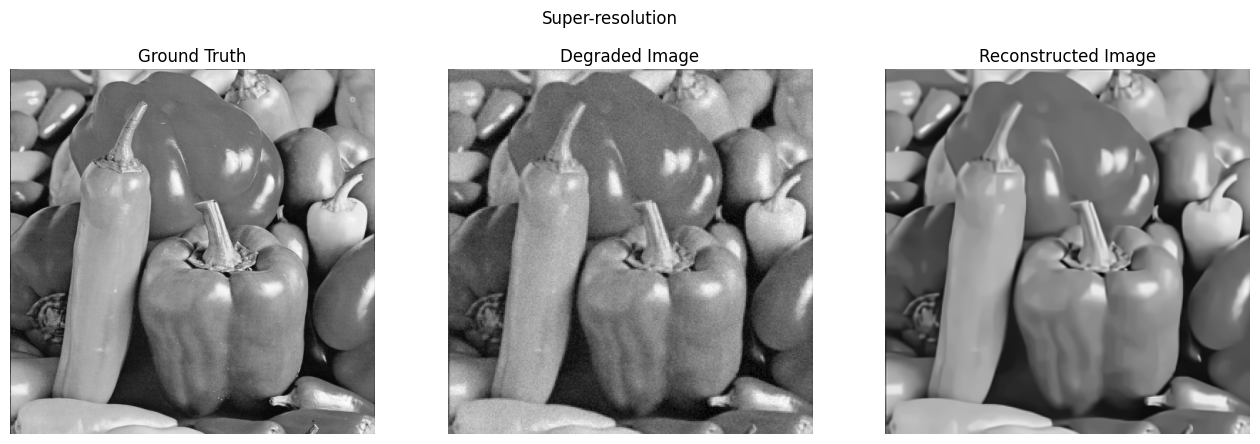

In [13]:
import matplotlib.pyplot as plt


# Load test image
z = np.mean(plt.imread('pepper.bmp'), axis=2) / 255.0

# Gaussian filter
h = fspecial_gauss(9, 1)

# Create degraded image
K = 2
noise_level = 5 / 255.0

y = imfilter(z, h)
y = downsample2(y, K)
y = y + noise_level * np.random.randn(*y.shape)
y = np.clip(y, 0, 1)

# Let's go
X = plug_and_play_admm_super(y, h, K, lmbda=0.001, denoiser=denoise_bm3d)

# Plot
plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
plt.title("Ground Truth")
plt.imshow(z, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Degraded Image")
plt.imshow(y, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Reconstructed Image")
plt.imshow(X, cmap='gray')
plt.axis('off')

plt.suptitle("Super-resolution")
plt.show()

### Deblur

iteration: 1, delta: 1.5151186110223693
iteration: 2, delta: 0.5339849343005157
iteration: 3, delta: 0.0486087680709594
iteration: 4, delta: 0.025082780874512677
iteration: 5, delta: 0.013233485839865297
iteration: 6, delta: 0.007273337545930359
iteration: 7, delta: 0.004265705811413702
iteration: 8, delta: 0.0027698177204144576
iteration: 9, delta: 0.002004545738760017
iteration: 10, delta: 0.0015836210822439563
iteration: 11, delta: 0.0013118069350557021
iteration: 12, delta: 0.0011399699648281193
iteration: 13, delta: 0.0010137996998137201
iteration: 14, delta: 0.0009010438532106729


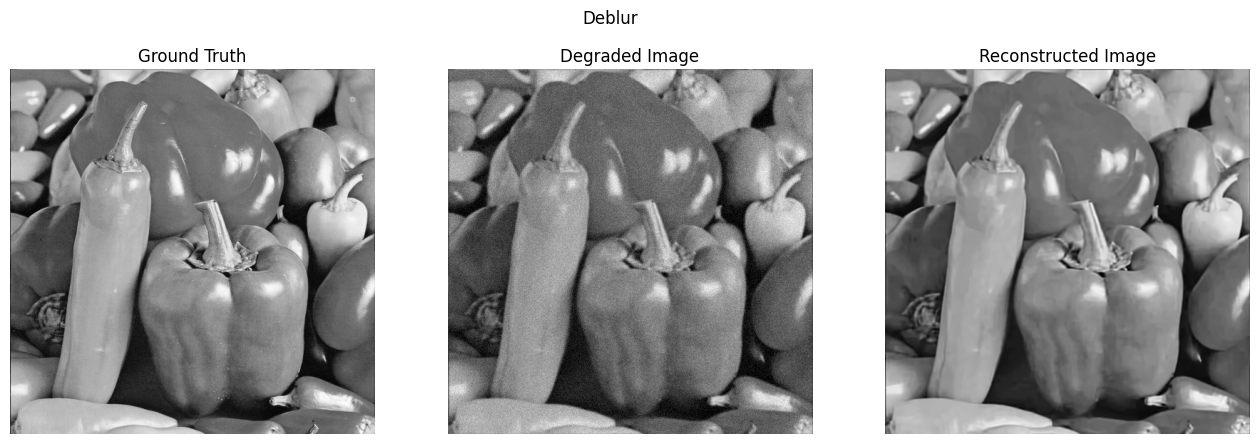

In [14]:
# Load test image
z = np.mean(plt.imread('pepper.bmp'), axis=2) / 255.0

# Gaussian filter
h = fspecial_gauss(9, 1)

# Create degraded image
K = 2
noise_level = 10 / 255.0

y = imfilter(z, h)
y = y + noise_level * np.random.randn(*y.shape)
y = np.clip(y, 0, 1)

# Let's go
X = plug_and_play_admm_deblur(y, h, lmbda=0.001, denoiser=denoise_bm3d)

# Plot
plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
plt.title("Ground Truth")
plt.imshow(z, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Degraded Image")
plt.imshow(y, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Reconstructed Image")
plt.imshow(X, cmap='gray')
plt.axis('off')

plt.suptitle("Deblur")
plt.show()